Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of an autoencoder with varying activation functions on an image reconstruction task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

We set the batch size, the number of epochs, and the number of units per layer.

In [4]:
batch_size = 256
epochs = 100
neurons = 512
code_dim = 128

## Data Preparation

We load the MNIST dataset.

In [5]:
(train_features, _), (test_features, _) = tf.keras.datasets.fashion_mnist.load_data()

We scale the images.

In [6]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We create a `tf.data.Dataset` object for the training dataset.

In [7]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_features))
dataset = dataset.batch(batch_size, True)
dataset = dataset.prefetch(batch_size * 4)
dataset = dataset.shuffle(train_features.shape[1])

## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [8]:
class AE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(AE, self).__init__()
        self.encoder_layer = tf.keras.layers.Dense(
            units=kwargs['units'],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.code = tf.keras.layers.Dense(
            units=kwargs['code_dim'],
            activation=tf.nn.sigmoid,
        )
        self.decoder_layer = tf.keras.layers.Dense(
            units=kwargs['units'],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.reconstructed = tf.keras.layers.Dense(
            units=kwargs['original_dim'],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
    
    @tf.function
    def call(self, features):
        activation = self.encoder_layer(features)
        code = self.code(activation)
        activation = self.decoder_layer(code)
        reconstructed = self.reconstructed(activation)
        return reconstructed

### Logistic-based Model

We define an autoencoder with a Logistic activation function.

In [9]:
model = AE(
    units=neurons,
    activation=tf.nn.sigmoid,
    initializer='glorot_uniform',
    code_dim=code_dim,
    original_dim=train_features.shape[1]
)

After defining our model, we shall now compile it for training.

In [10]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
)

Call the model.

In [11]:
model(train_features[:batch_size])

<tf.Tensor: id=178, shape=(256, 784), dtype=float32, numpy=
array([[0.49521345, 0.4983062 , 0.67502236, ..., 0.5186655 , 0.40712366,
        0.44193247],
       [0.4942115 , 0.4968806 , 0.6745033 , ..., 0.52009606, 0.4087699 ,
        0.44204164],
       [0.49476874, 0.49769777, 0.6753612 , ..., 0.5195075 , 0.40740666,
        0.4428568 ],
       ...,
       [0.49516493, 0.49754393, 0.67485625, ..., 0.518905  , 0.40906337,
        0.44152927],
       [0.49349675, 0.4982289 , 0.67586833, ..., 0.52008414, 0.40884596,
        0.44107845],
       [0.4949835 , 0.49829987, 0.6748968 , ..., 0.51925987, 0.40958005,
        0.44206926]], dtype=float32)>

Display model summary.

In [12]:
model.summary()

Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  401920    
_________________________________________________________________
dense_1 (Dense)              multiple                  65664     
_________________________________________________________________
dense_2 (Dense)              multiple                  66048     
_________________________________________________________________
dense_3 (Dense)              multiple                  402192    
Total params: 935,824
Trainable params: 935,824
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [13]:
logistic_performance = model.fit(
    dataset, epochs=epochs, verbose=0
)

#### Logistic-based AE Results

We plot the original images, the reconstructed images, and the difference between them.

Display the original images.

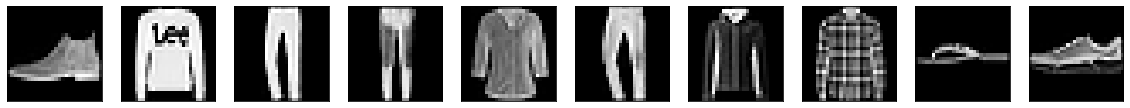

In [14]:
number = 10

plt.figure(figsize=(20, 4))
for index in range(number):    
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the reconstructed images.

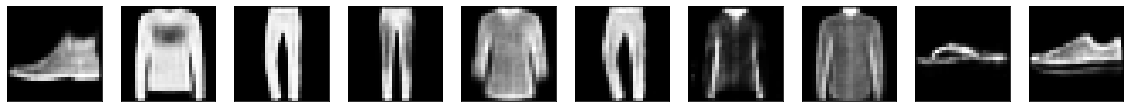

In [15]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    reconstructed = model(test_features[index].reshape(-1, 784)).numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the difference between the original images and their reconstruction.

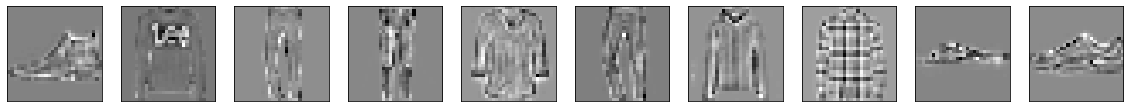

In [16]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    difference = model(test_features[index].reshape(-1, 784)) - test_features[index]
    difference = difference.numpy().reshape(28, 28)
    plt.imshow(difference)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### TanH-based Model

We define an autoencoder with a Hyperbolic Tangent activation function.

In [17]:
model = AE(
    units=neurons,
    activation=tf.nn.tanh,
    initializer='glorot_uniform',
    code_dim=code_dim,
    original_dim=train_features.shape[1]
)

After defining our model, we shall now compile it for training.

In [18]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
)

Train the model.

In [19]:
tanh_performance = model.fit(
    dataset, epochs=epochs, verbose=0
)

#### TanH-based AE Results

We plot the original images, the reconstructed images, and the difference between them.

Display the original images.

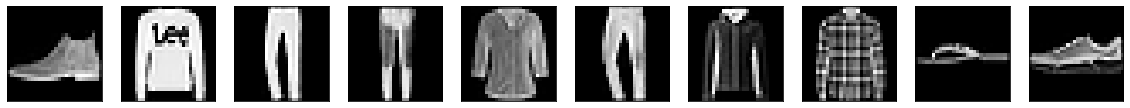

In [20]:
number = 10

plt.figure(figsize=(20, 4))
for index in range(number):    
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the reconstructed images.

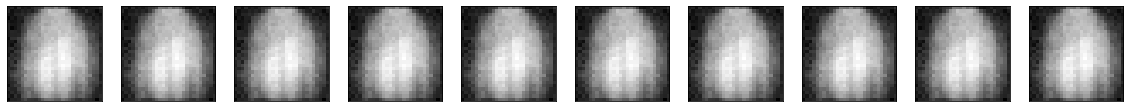

In [21]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    reconstructed = model(test_features[index].reshape(-1, 784)).numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the difference between the original images and their reconstruction.

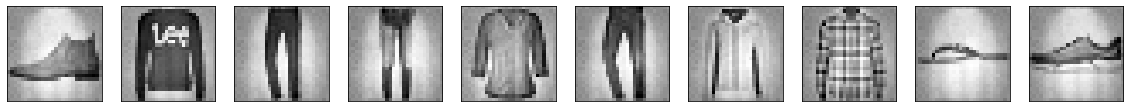

In [22]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    difference = model(test_features[index].reshape(-1, 784)) - test_features[index]
    difference = difference.numpy().reshape(28, 28)
    plt.imshow(difference)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### ReLU-based Model

We define an autoencoder with a ReLU activation function.

In [23]:
model = AE(
    units=neurons,
    activation=tf.nn.relu,
    initializer='he_normal',
    code_dim=code_dim,
    original_dim=train_features.shape[1]
)

After defining our model, we shall now compile it for training.

In [24]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
)

Train the model.

In [25]:
relu_performance = model.fit(
    dataset, epochs=epochs, verbose=0
)

#### ReLU-based AE Results

We plot the original images, the reconstructed images, and the difference between them.

Display the original images.

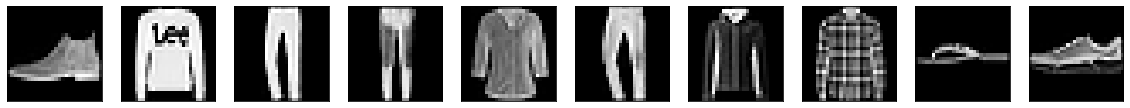

In [26]:
number = 10

plt.figure(figsize=(20, 4))
for index in range(number):    
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the reconstructed images.

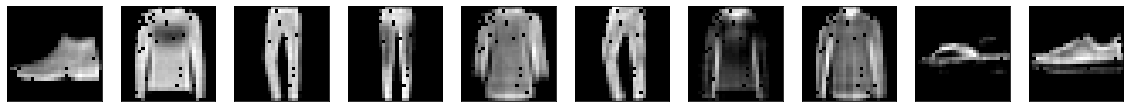

In [27]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    reconstructed = model(test_features[index].reshape(-1, 784)).numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the difference between the original images and their reconstruction.

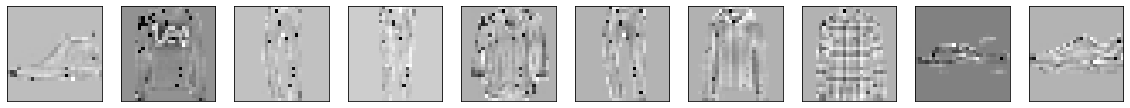

In [28]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    difference = model(test_features[index].reshape(-1, 784)) - test_features[index]
    difference = difference.numpy().reshape(28, 28)
    plt.imshow(difference)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Leaky ReLU-based Model

We define an autoencoder with a Leaky ReLU activation function.

In [29]:
model = AE(
    units=neurons,
    activation=tf.nn.leaky_relu,
    initializer='he_normal',
    code_dim=code_dim,
    original_dim=train_features.shape[1]
)

After defining our model, we shall now compile it for training.

In [30]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
)

Train the model.

In [31]:
lrelu_performance = model.fit(
    dataset, epochs=epochs, verbose=0
)

#### Leaky ReLU-based AE Results

We plot the original images, the reconstructed images, and the difference between them.

Display the original images.

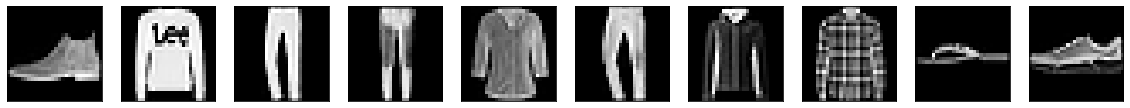

In [32]:
number = 10

plt.figure(figsize=(20, 4))
for index in range(number):    
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the reconstructed images.

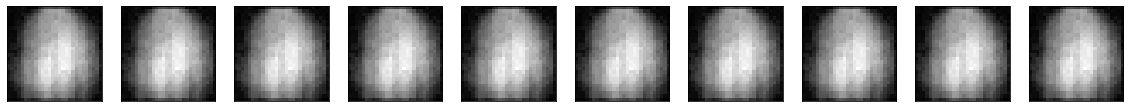

In [33]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    reconstructed = model(test_features[index].reshape(-1, 784)).numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the difference between the original images and their reconstruction.

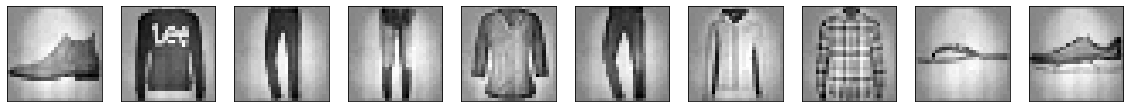

In [34]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    difference = model(test_features[index].reshape(-1, 784)) - test_features[index]
    difference = difference.numpy().reshape(28, 28)
    plt.imshow(difference)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Softplus-based Model

We define an autoencoder with a Softplus activation function.

In [35]:
model = AE(
    units=neurons,
    activation=tf.nn.softplus,
    initializer='he_normal',
    code_dim=code_dim,
    original_dim=train_features.shape[1]
)

After defining our model, we shall now compile it for training.

In [36]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
)

Train the model.

In [37]:
softplus_performance = model.fit(
    dataset, epochs=epochs, verbose=0
)

#### Softplus-based AE Results

We plot the original images, the reconstructed images, and the difference between them.

Display the original images.

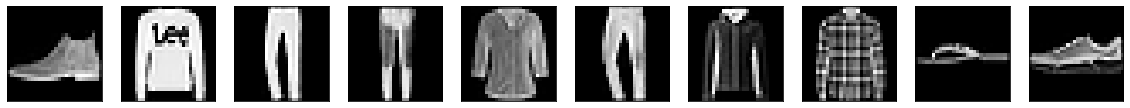

In [38]:
number = 10

plt.figure(figsize=(20, 4))
for index in range(number):    
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the reconstructed images.

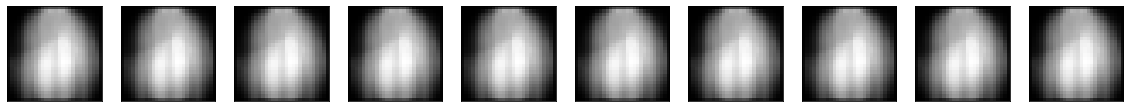

In [39]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    reconstructed = model(test_features[index].reshape(-1, 784)).numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the difference between the original images and their reconstruction.

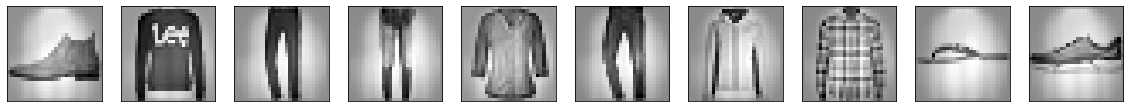

In [40]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    difference = model(test_features[index].reshape(-1, 784)) - test_features[index]
    difference = difference.numpy().reshape(28, 28)
    plt.imshow(difference)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### ELU-based Model

We define an autoencoder with a ELU activation function.

In [41]:
model = AE(
    units=neurons,
    activation=tf.nn.elu,
    initializer='he_normal',
    code_dim=code_dim,
    original_dim=train_features.shape[1]
)

After defining our model, we shall now compile it for training.

In [42]:
model.compile(
    loss=tf.losses.mean_squared_error,
    optimizer=tf.optimizers.Adam(learning_rate=1e-2),
)

Train the model.

In [43]:
elu_performance = model.fit(
    dataset, epochs=epochs, verbose=0
)

#### ELU-based AE Results

We plot the original images, the reconstructed images, and the difference between them.

Display the original images.

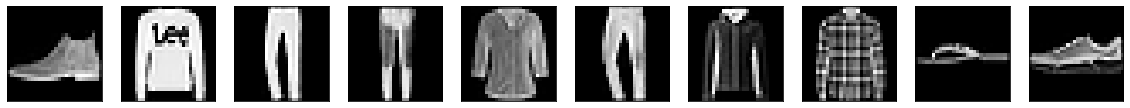

In [44]:
number = 10

plt.figure(figsize=(20, 4))
for index in range(number):    
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(test_features[index].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the reconstructed images.

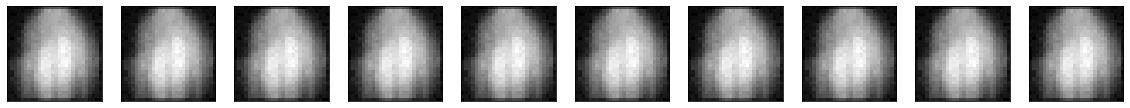

In [45]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1)
    reconstructed = model(test_features[index].reshape(-1, 784)).numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Display the difference between the original images and their reconstruction.

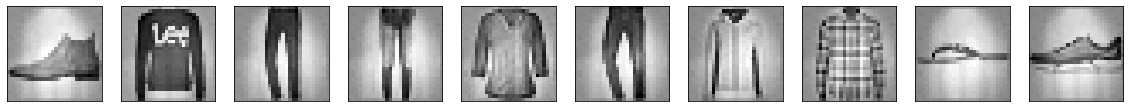

In [46]:
plt.figure(figsize=(20, 4))
for index in range(number):
    ax = plt.subplot(2, number, index + 1 + number)
    difference = model(test_features[index].reshape(-1, 784)) - test_features[index]
    difference = difference.numpy().reshape(28, 28)
    plt.imshow(difference)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

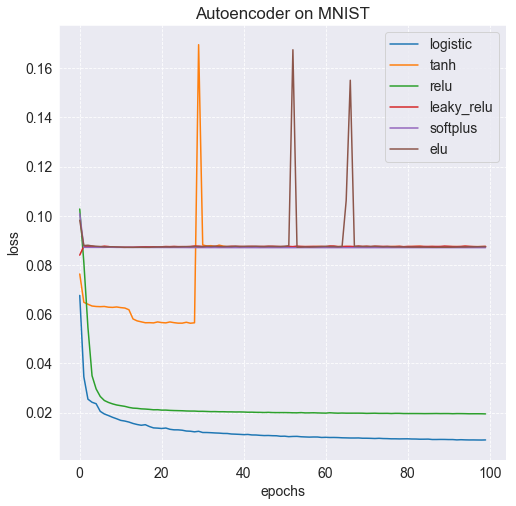

In [47]:
sns.set_style('dark', {'grid.linestyle': '--'})
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 14})

plt.plot(
    range(len(logistic_performance.history['loss'])),
    logistic_performance.history['loss'],
    label='logistic'
)
plt.plot(
    range(len(tanh_performance.history['loss'])),
    tanh_performance.history['loss'],
    label='tanh'
)
plt.plot(
    range(len(relu_performance.history['loss'])),
    relu_performance.history['loss'],
    label='relu'
)
plt.plot(
    range(len(lrelu_performance.history['loss'])),
    lrelu_performance.history['loss'],
    label='leaky_relu'
)
plt.plot(
    range(len(softplus_performance.history['loss'])),
    softplus_performance.history['loss'],
    label='softplus'
)
plt.plot(
    range(len(elu_performance.history['loss'])),
    elu_performance.history['loss'],
    label='elu'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.grid()
plt.title('Autoencoder on MNIST')
plt.savefig('ae_mnist_experiments.png', dpi=300)
plt.show()

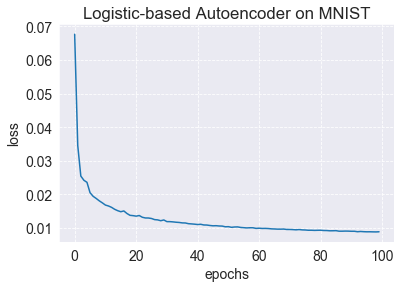

In [48]:
plt.plot(
    range(len(logistic_performance.history['loss'])),
    logistic_performance.history['loss'],
    label='logistic'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('Logistic-based Autoencoder on MNIST')
plt.show()

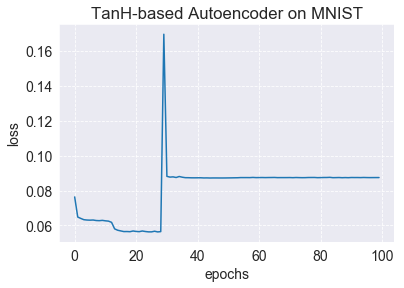

In [49]:
plt.plot(
    range(len(tanh_performance.history['loss'])),
    tanh_performance.history['loss'],
    label='tanh'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('TanH-based Autoencoder on MNIST')
plt.show()

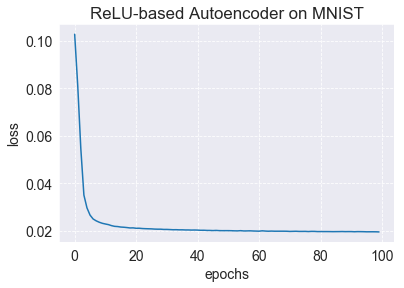

In [50]:
plt.plot(
    range(len(relu_performance.history['loss'])),
    relu_performance.history['loss'],
    label='relu'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('ReLU-based Autoencoder on MNIST')
plt.show()

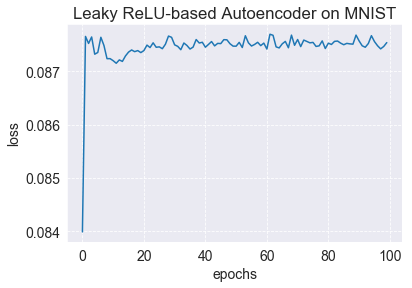

In [51]:
plt.plot(
    range(len(lrelu_performance.history['loss'])),
    lrelu_performance.history['loss'],
    label='leaky_relu'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('Leaky ReLU-based Autoencoder on MNIST')
plt.show()

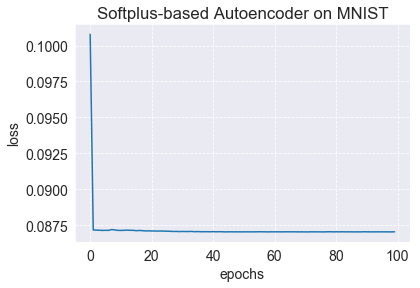

In [52]:
plt.plot(
    range(len(softplus_performance.history['loss'])),
    softplus_performance.history['loss'],
    label='softplus'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('Softplus-based Autoencoder on MNIST')
plt.show()

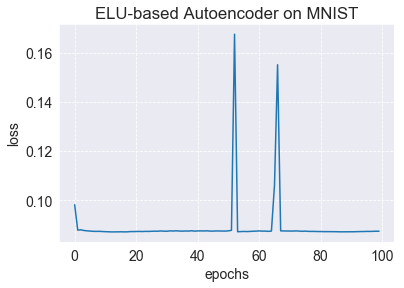

In [53]:
plt.plot(
    range(len(elu_performance.history['loss'])),
    elu_performance.history['loss'],
    label='elu'
)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('ELU-based Autoencoder on MNIST')
plt.show()